In [4]:
import numpy as np
import requests, gzip, os, hashlib

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
#fetch data
path=''
def fetch(url):
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            data = f.read()
    else:
        with open(fp, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

X = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [6]:
#Validation split
rand=np.arange(60000)
np.random.shuffle(rand)
train_no=rand[:50000]

val_no=np.setdiff1d(rand,train_no)

X_train,X_val=X[train_no,:,:],X[val_no,:,:]
Y_train,Y_val=Y[train_no],Y[val_no]



In [7]:
#Sigmoid funstion
def sigmoid(x):
   
    return 1/(np.exp(-x)+1)    

#derivative of sigmoid
def d_sigmoid(x):
    return (np.exp(-x))/((np.exp(-x)+1)**2)

In [8]:
#Softmax
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)



def relu(x):
    return np.maximum(0, x)

def d_relu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

#derivative of softmax
def d_softmax(x):
    soft = softmax(x)
    return soft * (1 - soft)


In [9]:
def init(x,y):
    layer=np.random.uniform(-1.,1.,size=(x,y))/np.sqrt(x*y)
    return layer.astype(np.float32)

np.random.seed(42)
l1=init(28*28,500)
l2=init(500,128)
l3=init(128,10) #10 units corresponding to digits 0–9.

In [10]:
Y_train

array([6, 8, 2, ..., 9, 8, 7], dtype=uint8)

In [11]:
ex=np.array(Y_train[1]).reshape(1,1)
ex

array([[8]], dtype=uint8)

In [12]:
example_out = np.zeros((len(ex),10), np.float32)
example_out[range(example_out.shape[0]),ex] = 1
example_out

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In the first line x is matrix multiplied with the first layer and is normalized by passing through the sigmoid function.
The sigmoid product is later matrix multiplied with the second layer and is passed through the softmax function to get the output vector of size 10, similar to our target vector.



In [13]:
#forward and backward pass
def forward_backward_pass(x,y):
    targets = np.zeros((len(y),10), np.float32)
    targets[range(targets.shape[0]),y] = 1
 
    
    x_l1=x.dot(l1)
    x_sigmoid=relu(x_l1)
    x_l2=x_sigmoid.dot(l2)
    x_sigmoid1=relu(x_l2)
    x_l3=x_sigmoid1.dot(l3)
    out=softmax(x_l3)
    
   
 
    error=2*(out-targets)/out.shape[0]*d_softmax(x_l3)
    update_l3=x_sigmoid1.T@error

    error=((l3).dot(error.T)).T*d_relu(x_l2)
    update_l2=x_sigmoid.T@error

    
    error=((l2).dot(error.T)).T*d_relu(x_l1)
    update_l1=x.T@error

    return out,update_l1,update_l2,update_l3


In [14]:
epochs=10000
lr=0.05
batch=128

losses,accuracies,val_accuracies=[],[],[]

def cross_entropy(y_pred, y_true):
 
    return -np.mean(y_true * np.log(y_pred))


for i in range(epochs):
    sample=np.random.randint(0,X_train.shape[0],size=(batch))
    x=X_train[sample].reshape((-1,28*28))
    y=Y_train[sample]
 

    out,update_l1,update_l2, update_l3=forward_backward_pass(x,y)
  
    category=np.argmax(out,axis=1)
    accuracy=(category==y).mean()
    accuracies.append(accuracy)
    
    #loss=((category-y)**2).mean()
    loss=cross_entropy(category,y)
    losses.append(loss.item())

    
    l1=l1-lr*update_l1
    l2=l2-lr*update_l2
    l3=l3-lr*update_l3
    
    if(i%20==0):    
        X_val=X_val.reshape((-1,28*28))
        val_out=np.argmax(softmax(relu(X_val.dot(l1)).dot(l2).dot(l3)),axis=1)
        val_acc=(val_out==Y_val).mean()
        val_accuracies.append(val_acc.item())
    if(i%500==0): print(f'For {i}th epoch: train accuracy: {accuracy:.3f} | validation accuracy:{val_acc:.3f}')




For 0th epoch: train accuracy: 0.086 | validation accuracy:0.229


/var/folders/v0/c7gvrc_919bgy_fxmbsq_0lw0000gn/T/ipykernel_59149/3960878350.py:9: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y_true * np.log(y_pred))
/var/folders/v0/c7gvrc_919bgy_fxmbsq_0lw0000gn/T/ipykernel_59149/3960878350.py:9: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y_true * np.log(y_pred))


For 500th epoch: train accuracy: 0.961 | validation accuracy:0.945
For 1000th epoch: train accuracy: 0.984 | validation accuracy:0.960
For 1500th epoch: train accuracy: 0.984 | validation accuracy:0.971
For 2000th epoch: train accuracy: 0.984 | validation accuracy:0.972
For 2500th epoch: train accuracy: 0.992 | validation accuracy:0.970
For 3000th epoch: train accuracy: 1.000 | validation accuracy:0.973
For 3500th epoch: train accuracy: 0.992 | validation accuracy:0.974
For 4000th epoch: train accuracy: 1.000 | validation accuracy:0.975
For 4500th epoch: train accuracy: 0.992 | validation accuracy:0.976
For 5000th epoch: train accuracy: 1.000 | validation accuracy:0.977
For 5500th epoch: train accuracy: 1.000 | validation accuracy:0.978
For 6000th epoch: train accuracy: 1.000 | validation accuracy:0.973
For 6500th epoch: train accuracy: 1.000 | validation accuracy:0.978
For 7000th epoch: train accuracy: 0.992 | validation accuracy:0.978
For 7500th epoch: train accuracy: 1.000 | validat

l1=init(28*28,500)
l2=init(500,128)
l3=init(128,10) 

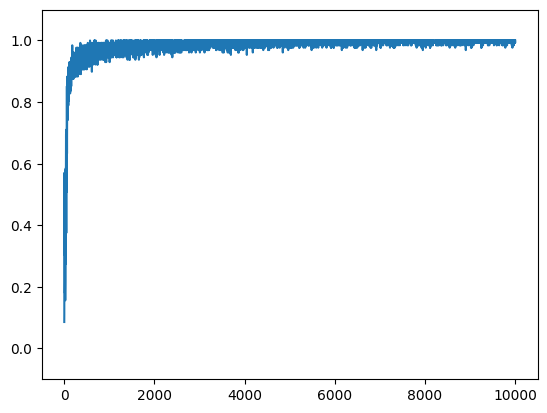

In [15]:
plt.ylim(-0.1, 1.1)
plot(accuracies)


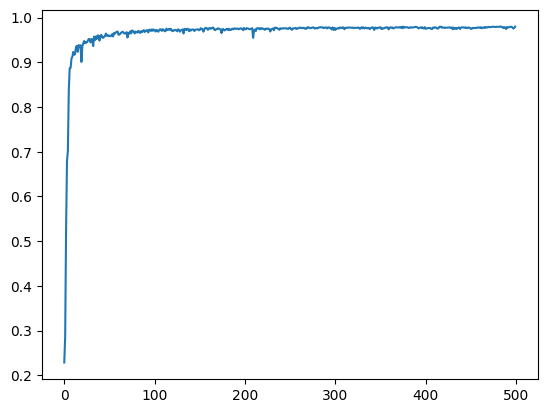

In [16]:
plot(val_accuracies)

In [17]:
test_out=np.argmax(softmax(sigmoid(X_test.dot(l1)).dot(l2)),axis=1)
test_acc=(test_out==Y_test).mean().item()
print(f'Test accuracy = {test_acc*100:.2f}%')
 

Test accuracy = 0.07%


/var/folders/v0/c7gvrc_919bgy_fxmbsq_0lw0000gn/T/ipykernel_59149/1461568531.py:4: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp(-x)+1)


array([115])

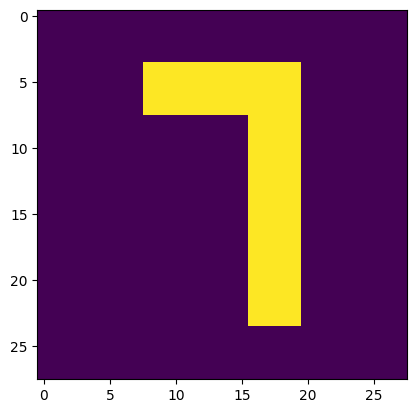

In [18]:
m = [[0,0,0,0,0,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,0,0,0]]

m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
m=m.reshape(1,-1)
imshow(m.reshape(28,28))
x = np.argmax(sigmoid(m.dot(l1)).dot(l2),axis=1)
x

array([72])

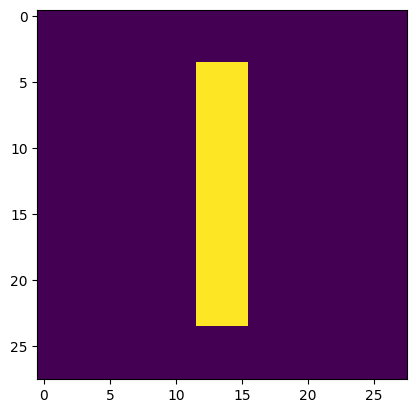

In [19]:
n = [[0,0,0,0,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,0,0,0,0]]

n = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in n])
n=n.reshape(1,-1)
imshow(n.reshape(28,28))
x = np.argmax(sigmoid(n.dot(l1)).dot(l2),axis=1)
x

In [20]:
import jovian
jovian.commit()

ModuleNotFoundError: No module named 'jovian'